### Import Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
import tensorflow as tf  # Main TensorFlow import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

### Load Dataset

In [24]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

### Train, Test, Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Standardize Data

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build Model Architecture

In [27]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        units=hp.Int('input_units', min_value=16, max_value=128, step=16),
        input_dim=X_train.shape[1],
        activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Hidden layers (1-3 tunable)
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'hidden_units_{i}', min_value=8, max_value=64, step=8),
            activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),  # Now properly referenced
                tf.keras.metrics.Recall(name='recall')])
    return model

### Hyperparameter Tuning

In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='breast_cancer')

tuner.search(X_train, y_train, 
             epochs=50, 
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=3)])

Reloading Tuner from tuner_results\breast_cancer\tuner0.json


### Best Model

In [29]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
Optimal Hyperparameters:
- Input units: {best_hps.get('input_units')}
- Hidden layers: {best_hps.get('n_layers')}
- Learning rate: {best_hps.get('learning_rate')}
""")

c:\Users\Ibrahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Optimal Hyperparameters:
- Input units: 16
- Hidden layers: 1
- Learning rate: 0.01



c:\Users\Ibrahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Train, Test, Split, Evaluate

In [30]:
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1)
# Evaluation
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9603 - loss: 0.1323 - precision: 0.9608 - recall: 0.9775 - val_accuracy: 0.9561 - val_loss: 0.0909 - val_precision: 0.9855 - val_recall: 0.9444
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9610 - loss: 0.1056 - precision: 0.9599 - recall: 0.9761 - val_accuracy: 0.9474 - val_loss: 0.0971 - val_precision: 0.9853 - val_recall: 0.9306
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9777 - loss: 0.0766 - precision: 0.9701 - recall: 0.9950 - val_accuracy: 0.9561 - val_loss: 0.0960 - val_precision: 0.9855 - val_recall: 0.9444
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9674 - loss: 0.0955 - precision: 0.9678 - recall: 0.9806 - val_accuracy: 0.9649 - val_loss: 0.0873 - val_precision: 0.9857 - val_recall: 0.9583
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9779 - loss: 0.0679 - precision: 0.9732 - recall: 0.9919 - val_accuracy: 0.9561 - val_loss: 0.1072

### Confusion Matrix

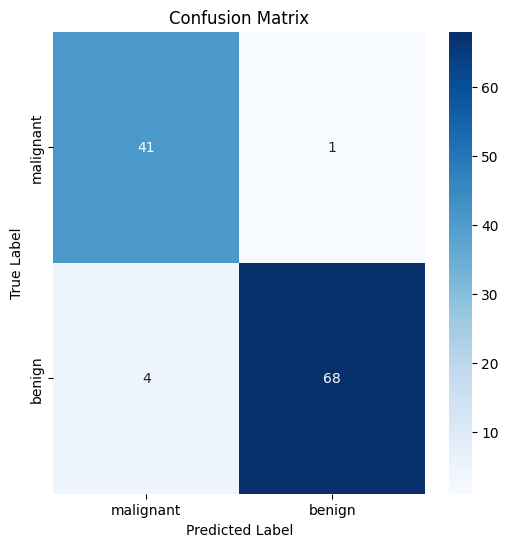

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC Curve

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


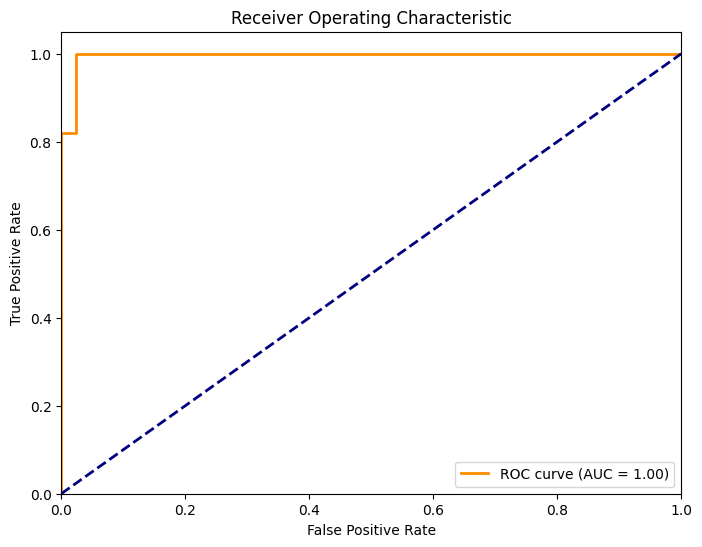

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()